In [1]:
%matplotlib inline

In [2]:
#!conda install geopandas
#!pip install geopandas pandas_bokeh

In [19]:
import os
import glob
import numpy as np
import pandas as pd
# Import geopandas package
import geopandas as gpd
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from matplotlib.pyplot import figure
from tqdm import tqdm_notebook as tqdm
from shapely.geometry import Point # Shapely for converting latitude/longtitude to geometry

input_dir = r'../../../datasets/OCO2/csv/'
#input_dir = r'../pipeline/'

In [21]:
dir = os.path.realpath(input_dir)
print(dir)
csv_list = glob.glob(input_dir + "result_"+"*.csv")
# # Initialize array to store data
df_res = pd.DataFrame()
# Loop over the files
for one_file in tqdm(csv_list):
    #print('Reading', one_file)
    df_temp = pd.read_csv(one_file, sep=",")
    df_res = df_res.append(df_temp)



# creating a geometry column 
geometry = [Point(xy) for xy in zip(df_res['longitude'], df_res['latitude'])]

# Coordinate reference system : WGS84
crs = {'init': 'epsg:4326'}

# Creating a Geographic data frame 
gdf_res = gpd.GeoDataFrame(df_res.copy(), crs=crs, geometry=geometry)



/media/data-nvme/dev/datasets/OCO2/csv


In [22]:
df_res.tail(3)

,Unnamed: 0,sounding_id,latitude,longitude,orbit,slope,intercept,amplitude,sigma,delta,R,windspeed_u,windspeed_v
2310,2310,2018083121065204,41.198765,-119.883293,22158,-0.007474,403.425331,62.566444,12.739404,1.959307,0.634265,1.770853,-1.712408
2311,2311,2018083121071177,42.348312,-120.247665,22158,-0.004479,402.411350,14.690829,13.771411,0.425577,0.500991,1.969038,-1.900701
2312,2312,2018083121075137,44.713779,-121.062645,22158,-0.001175,401.793611,15.188079,4.922932,1.230805,0.554179,2.222045,-1.855168


In [23]:
gdf_res.tail(3)

,Unnamed: 0,sounding_id,latitude,longitude,orbit,slope,intercept,amplitude,sigma,delta,R,windspeed_u,windspeed_v,geometry
2310,2310,2018083121065204,41.198765,-119.883293,22158,-0.007474,403.425331,62.566444,12.739404,1.959307,0.634265,1.770853,-1.712408,POINT (-119.8832931518555 41.19876480102539)
2311,2311,2018083121071177,42.348312,-120.247665,22158,-0.004479,402.411350,14.690829,13.771411,0.425577,0.500991,1.969038,-1.900701,POINT (-120.2476654052734 42.34831237792969)
2312,2312,2018083121075137,44.713779,-121.062645,22158,-0.001175,401.793611,15.188079,4.922932,1.230805,0.554179,2.222045,-1.855168,POINT (-121.0626449584961 44.71377944946289)


In [6]:
len(df_res)

2313

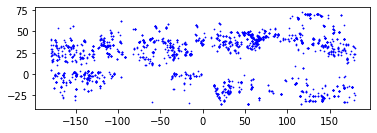

In [7]:
# Plot all points
gdf_res.plot(marker='o', color='b', markersize=0.5)

In [8]:
def draw_map_df(data, x="longitude", y="latitude", c="xco2", lon_min=-180, lon_max=180, lat_min=-90, lat_max=90, size_point=1, frontier=False):

    plt.figure(figsize=(15, 10), edgecolor='w')
    m = Basemap(llcrnrlat=lat_min, urcrnrlat=lat_max, llcrnrlon=lon_min, urcrnrlon=lon_max)
    
    m.shadedrelief()
    
    parallels = np.arange(-80.,81,10.)
    m.drawparallels(parallels,labels=[False,True,True,False])

    meridians = np.arange(10.,351.,20.)
    m.drawmeridians(meridians,labels=[True,False,False,True])

    normal = matplotlib.colors.LogNorm(vmin=data[c].min(), vmax=data[c].max())

    m.scatter(data[x], data[y], c=data[c], cmap=plt.cm.jet, s=size_point, norm=normal)

    if (frontier):
      m.drawcountries(linewidth=0.5)
      m.drawcoastlines(linewidth=0.7)

    plt.show()

<Figure size 800x640 with 0 Axes>

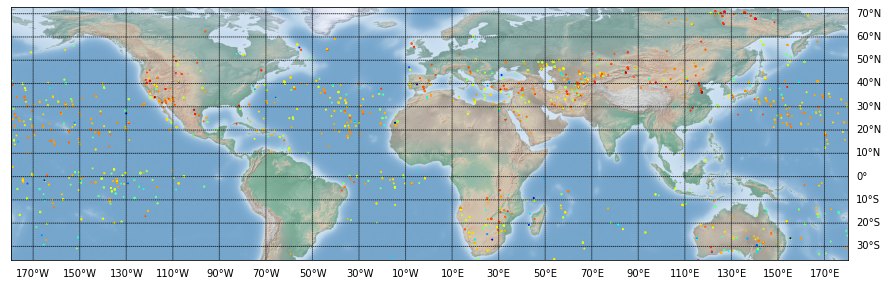

In [9]:
figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
draw_map_df(df_res, c='delta', lon_min=min(df_res['longitude']), lon_max=max(df_res['longitude']), lat_min=min(df_res['latitude']), lat_max=max(df_res['latitude']))

In [10]:
#!conda install bokeh

## Conversion de coordonnées

On peut se référer aux projections à travers les codes « EPSG », qui sont des identificateurs de SIG nommés et gérés par l’European Petroleum Survey Group.
La projection Sphérique de Mercator est identifiée comme EPSG: 3857. Ces coordonnées sont en mètres et exprimées par x / y.

L’autre code EPSG commun est EPSG:4326, qui utilise le WGS84 comme système de coordonnées. Il décrit des coordonnées (latitude / longitude).

Les données OCO2 sont en EPSG:4326 alors que Bokeh attend des coordonnées EPSG:3857. Il faut donc faire une conversion.

In [38]:
import pyproj

gps_projection = pyproj.Proj("EPSG:4326")  # GPS
mercator_projection = pyproj.Proj("EPSG:3857")  # Mercator

df_res['x'], df_res['y'] = pyproj.transform(gps_projection, mercator_projection, df_res['latitude'].tolist(), df_res['longitude'].tolist())
df_res['size'] = df_res['delta']*4
df_res.head(3)

,Unnamed: 0,sounding_id,latitude,longitude,orbit,slope,intercept,amplitude,sigma,delta,R,windspeed_u,windspeed_v,x,y,size
0,0,2018080101035604,25.425072,-177.345490,21709,-0.000017,404.786068,-9.322890,-3.818291,0.974073,0.660388,-7.759225,-0.739198,-1.974201e+07,2.928046e+06,3.896292
1,1,2018080101050203,29.112371,-178.352524,21709,-0.001326,405.023519,2.480614,2.097535,0.471802,0.651822,-6.748729,-1.210935,-1.985411e+07,3.389956e+06,1.887209
2,2,2018080101062177,33.494995,-179.648438,21709,-0.002496,404.507099,6.427538,2.924886,0.876690,0.698739,-4.581494,-0.911555,-1.999837e+07,3.961192e+06,3.506758


In [37]:

inProj = pyproj.Proj('epsg:4326')
outProj = pyproj.Proj('epsg:3857')
x1,y1 = -177.345490, 25.425072
x2,y2 = pyproj.transform(inProj,outProj,x1,y1)
print(x2,y2)

inf inf


In [31]:
df_res.tail(3)

,Unnamed: 0,sounding_id,latitude,longitude,orbit,slope,intercept,amplitude,sigma,delta,R,windspeed_u,windspeed_v,x,y,size
2310,2310,2018083121065204,41.198765,-119.883293,22158,-0.007474,403.425331,62.566444,12.739404,1.959307,0.634265,1.770853,-1.712408,inf,inf,7.837227
2311,2311,2018083121071177,42.348312,-120.247665,22158,-0.004479,402.411350,14.690829,13.771411,0.425577,0.500991,1.969038,-1.900701,inf,inf,1.702307
2312,2312,2018083121075137,44.713779,-121.062645,22158,-0.001175,401.793611,15.188079,4.922932,1.230805,0.554179,2.222045,-1.855168,inf,inf,4.923218


In [28]:
# Crash notebook :-(
# import pandas_bokeh
# pandas_bokeh.output_notebook()
# df_res.plot_bokeh(simplify_shapes=10000)

In [29]:
df_res.columns

Index(['Unnamed: 0', 'sounding_id', 'latitude', 'longitude', 'orbit', 'slope',
       'intercept', 'amplitude', 'sigma', 'delta', 'R', 'windspeed_u',
       'windspeed_v', 'x', 'y', 'size'],
      dtype='object')

In [43]:
from bokeh.plotting import figure, output_file, show
#from bokeh.tile_providers import CARTODBPOSITRON, get_provider
from bokeh.tile_providers import CARTODBPOSITRON, get_provider
from bokeh.models import ColumnDataSource, HoverTool
from bokeh.models import GeoJSONDataSource
from bokeh.io import output_notebook
output_notebook()

source = ColumnDataSource(data=df_res)
output_file("peak_map.html")

tile_provider = get_provider(CARTODBPOSITRON)
hover = HoverTool(tooltips=[
    ("sounding_id", "@sounding_id"),
    ("delta", "@delta"),
    ("windspeed_u","@windspeed_u")
])

p = figure(x_range=(-3000000, 5000000), y_range=(-100000, 8000000), plot_width=1200, plot_height=800,
           x_axis_type="mercator", y_axis_type="mercator"
          ,tools=[hover, 'wheel_zoom','save','box_zoom','reset']
          )
p.add_tile(tile_provider)

p.circle(x='x', y='y', source=source,size='size',
         line_color="#FF0000", 
         fill_color="#FF0000",
         fill_alpha=0.01)

show(p)

Loading BokehJS ...

In [ ]:
# ODIAC - https://colab.research.google.com/drive/1pERH_iSkIkMYy1MDe_MAWTUs2MoPRa7x#scrollTo=uR8cnThg-paEwc
path6 = "/content/drive/My Drive/Data For Good/odiac2019_1x1d_2018.nc"
http://datasets.wri.org/dataset/globalpowerplantdatabase%22

In [ ]:
# from bokeh.plotting import figure, show
# from bokeh.io import output_notebook
# output_notebook()
# p = figure(plot_width=400, plot_height=400)
# p.circle([1, 2, 3, 4, 5], [6, 7, 2, 4, 5], size=15, line_color="navy", fill_color="orange", fill_alpha=0.5)
# show(p)